In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px

from sklearn import metrics 
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree


In [5]:
water_data = pd.read_csv("data/water_potability.csv")
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

X, y = water_data.drop('Potability', axis=1), water_data['Potability']

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
 
# Train F1 score: 1.00
# Valid F1 score: 0.67

Train F1 score: 1.00
Valid F1 score: 0.67


In [6]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.06575251, 0.05198574, 0.05168104, 0.05289936, 0.06473732]),
 'score_time': array([0.00455999, 0.00555587, 0.00410485, 0.00202847, 0.00254846]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [7]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


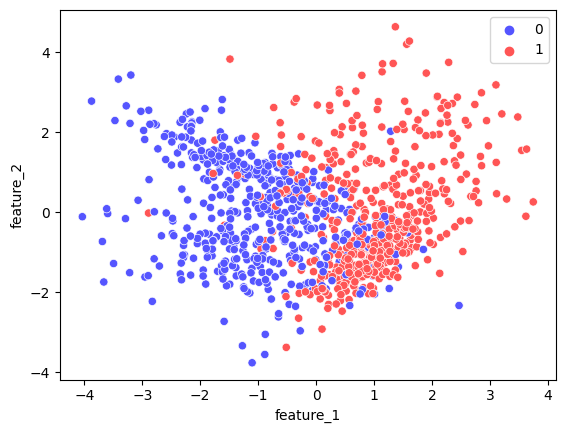

In [13]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

In [14]:
X_train_s, X_valid_s, y_train_s, y_valid_s = model_selection.train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [15]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,
        y, test_size=0.3, random_state=42)

tree_model = tree.DecisionTreeClassifier(
    max_depth=10
)

tree_model.fit(X_train, y_train)

y_train_predict = tree_model.predict(X_train)
y_valid_predict = tree_model.predict(X_valid)

print(round(metrics.accuracy_score(y_train,y_train_predict),2))
print(round(metrics.accuracy_score(y_valid,y_valid_predict),2))


0.98
0.82


МЕТОДЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ

Мы посмотрели, как с помощью методов валидации можно определить наличие переобучения. Но как с ним бороться?

Существует несколько основных способов, и с каждым из них мы уже знакомились в нашем курсе. Ключевая идея, заложенная в каждом из методов, звучит так: снизить переобучение = уменьшить разброс (вариативность) ошибки

In [17]:
print('Current depth:', model_bad.get_depth())
## Current depth: 27

Current depth: 27



Дерево глубиной 27 — это очень сложная модель. Давайте попробуем её упростить, добавив в дерево решений ограничение на глубину (max_depth). Пусть максимальная глубина дерева будет равна 7.

In [18]:

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


## Train k-fold mean f1: 0.75
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.92
Valid k-fold mean f1: 0.84


После ограничения максимальной глубины удалось уменьшить разницу между метриками на тренировочных и валидационных фолдах кросс-валидации.

Попробуйте самостоятельно изменять глубину дерева в большую и меньшую сторону и проследите, как меняется значение метрик на кросс-валидации.

Попробуем добавить ещё одно ограничение к нашему дереву: увеличим количество объектов, которых достаточно для образования листа дерева (min_samples_leaf). По умолчанию этот параметр равен 1. 

Напомним интерпретацию данного параметра. Пусть min_samples_leaf=5. Допустим, в результате разделения получается две вершины: первая — с четырьмя объектами, а вторая — с шестью. Тогда дерево разрешит снова делиться только второй вершине (6 > min_samples_leaf), а первая вершина (4 < min_samples_leaf) дерева превратится в лист, и её деление будет остановлено.

In [19]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 0.74
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.91
Valid k-fold mean f1: 0.85


Обучите модель дерева решений с глубиной 3 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке.

Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.

В качестве ответа укажите значение метрики accuracy на тренировочной и валидационной выборках. Ответ округлите до двух знаков после точки-разделителя.

Accuracy на тренировочной выборке:

In [20]:
tree_model = tree.DecisionTreeClassifier(
    max_depth=3
)

tree_model.fit(X_train_s, y_train_s)

y_train_predict = tree_model.predict(X_train_s)
y_valid_predict = tree_model.predict(X_valid_s)

print(round(metrics.accuracy_score(y_train_s,y_train_predict),2))
print(round(metrics.accuracy_score(y_valid_s,y_valid_predict),2))

0.88
0.85
